
<h1><b>M5 Forecasting: Naive Approaches</b></h1>




# **Contents**

<h3> 1. Load and Extract Data </h3> 

<h3> 2. Reading the Data </h3> 

<h3> 3. Data Wrangling</h3> 

<h3> 4. Split the data</h3> 

<h3> 5. Define functions to compute weights and metrics</h3> 

<h3> 6. Naive Approaches</h3> 

<h3> 7. Summary</h3> 

<h3> 8. References</h3> 



In [ ]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import seaborn as sns
from tqdm import tqdm
import random 
import datetime

# 1. Load and Extract Data 

## 1.1 Loading Data from Kaggle

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1664694492&Signature=L88PXp6ATJK53ZPmUmNBzarZiaj4GPOArtp%2BERA8mUBst1g3JVYmYJOirBvkZMXxWpMWi8aizu99BqcP2SA8QCy4apJsWcEvUK8EoTMaJxZ4C340l9B6yt%2FrC3t8ZCmcSX%2FdEXfhn7iGrb%2FZGeUHY1scWJG3uwzPnYRxOqPuoLgxYMC89t%2Bt%2FVjEnOdlsE7vuPOIlY6W7df2Vy9C2elIQsXcvHrF%2F26HcshEWGXr4tgb8d4C8gkCko3NXDGZh973d9H2FoFkaU7Vl4CpNzBpwj8ov9ZH5ZBLPRtahjJ%2FTarIZQhDhWCe9wr2oa9zOJileVO039oagouAWtjwbp%2F0MA%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -c -O 'm5-forecasting-accuracy.zip'

--2022-09-29 07:08:50--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1664694492&Signature=L88PXp6ATJK53ZPmUmNBzarZiaj4GPOArtp%2BERA8mUBst1g3JVYmYJOirBvkZMXxWpMWi8aizu99BqcP2SA8QCy4apJsWcEvUK8EoTMaJxZ4C340l9B6yt%2FrC3t8ZCmcSX%2FdEXfhn7iGrb%2FZGeUHY1scWJG3uwzPnYRxOqPuoLgxYMC89t%2Bt%2FVjEnOdlsE7vuPOIlY6W7df2Vy9C2elIQsXcvHrF%2F26HcshEWGXr4tgb8d4C8gkCko3NXDGZh973d9H2FoFkaU7Vl4CpNzBpwj8ov9ZH5ZBLPRtahjJ%2FTarIZQhDhWCe9wr2oa9zOJileVO039oagouAWtjwbp%2F0MA%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 74.125.31.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48009163 (46M) [application/zip]
Saving to: ‘m5-forecasting-accuracy.zi

## 1.2 Extracting Data from Zip

In [ ]:
with ZipFile('/content/m5-forecasting-accuracy.zip') as z: 
    z.extractall()

# 2. Reading the Data

In [ ]:
df_sales = pd.read_csv('/content/sales_train_evaluation.csv')
df_price = pd.read_csv('/content/sell_prices.csv')
df_cal = pd.read_csv('/content/calendar.csv')

# 3. Data Wrangling

In [ ]:
#add id column to df_price
df_price["id"] = df_price[["item_id","store_id"]].apply(lambda x: x[0]+'_'+x[1]+'_evaluation', axis=1) 
df_price.head(3)

,store_id,item_id,wm_yr_wk,sell_price,id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1_evaluation
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1_evaluation
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1_evaluation


In [ ]:
#add a feature which indicates the day number
df_cal["d_"] = df_cal["d"].apply(lambda x: int(x.split("_")[1]))

#merge event_name_1, event_name_2 and event_type_1, event_type_2 together
df_cal['event_name_1'] = df_cal['event_name_1'].apply(lambda x: "".join(x.split(" ")) if type(x)==str else x)
df_cal['event_name_2'] = df_cal['event_name_2'].apply(lambda x: "".join(x.split(" ")) if type(x)==str else x)

df_cal['event_name'] = df_cal[['event_name_1', 'event_name_2']].apply(lambda x: "_".join([x[0], x[1]]) if type(x[1])==str else x[0], axis=1)
df_cal['event_type'] = df_cal[['event_type_1', 'event_type_2']].apply(lambda x: "_".join([x[0], x[1]]) if type(x[1])==str else x[0], axis=1)

df_cal.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace=True)
df_cal.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,d_,event_name,event_type
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,1,NaN,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,2,NaN,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,3,NaN,NaN


#4. Split the data

In [ ]:
all_days = [x for x in df_sales.columns if 'd_' in x]

train = df_sales[all_days[:1913]]
val = df_sales[all_days[1913:]]

# 5. Define function to calculate weights and metrics



## 5.1 Compute Weights

In [ ]:
level_groupings = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"],
                   8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"], 10: ["item_id"], 11: ["item_id", "state_id"]}

def calculate_weightsL12(sales, cal, price):
    ''' Calculate weights for level 12 (Product-Store) series' using the last 28 days sales data '''

    #calculating weights for level 12 : 'item_id, store_id' # (d_1886 to d_1913)
    #this loop is repeated 28 times to get the sales volume of all ids for each of last 28 days 
    #flow of execution : day-> week id-> sell price of ids on the day-> sales revenue of ids for the day
    for day in tqdm(range(1886, 1914)):  
        #get the week id corresponding to the day 
        week_id = int(cal[cal["d_"]==day]["wm_yr_wk"]) 

        #get the week price for each of the items corresponding to the week id   
        week_price = price[price["wm_yr_wk"]==week_id]

        #merge sales with week price on 'id'
        #note: we merge the dataframes using inner join so the id which are present in both dataframes will be retained after merging
        sales = sales.merge(week_price[["sell_price", "id"]], on=["id"], how='inner')

        #create a column which shows the sales revenue for the day
        #sales revenue = sell_price * units_sold 
        sales["sales_revenue_d_" + str(day)] = sales["sell_price"] * sales["d_" + str(day)]

        #drop the sell_price column
        sales.drop(columns=["sell_price"], inplace=True)

    #Sum of sales revenue of each id for last 28 days   1`
    sales_revenue_cols = [x for x in sales.columns if x.find("sales_revenue")==0]
    sales['sales_revenue_alldays'] = sales[sales_revenue_cols].sum(axis=1)
    #Compute weights for each Level 12 Time Series
    sales['weight'] = (1/12)*(sales['sales_revenue_alldays']/sales['sales_revenue_alldays'].sum())
    #Drop the unnecessary columns 
    sales.drop(columns = sales_revenue_cols+['sales_revenue_alldays'], inplace=True)

    return sales

def calculate_weightsALL(sales, levels):
    ''' Calculate weights for series' in rest of the aggregation levels '''
    #weights for level 1 : 'all'
    agg = pd.DataFrame(sales[[x for x in sales.columns if x.find("d_") == 0 or x.find("F_") == 0]].sum()).transpose() 
    id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
    for col in id_cols:
        agg[col] = 'all'
    agg["level"] = 1
    agg["weight"] = 1/12
    column_order = agg.columns

    #weights for the rest of the levels
    for level in tqdm(level_groupings):
        temp_df = sales.groupby(by=level_groupings[level]).sum().reset_index()
        temp_df["level"] = level
        
        for c in column_order:
            if c not in temp_df.columns:
                temp_df[c] = 'all'
                
        agg = agg.append(temp_df[column_order])

    return agg

## 5.2 Compute WRMSSE

Download pdf from here to understand the aim, data and metric - https://mofc.unic.ac.cy/m5-competition/

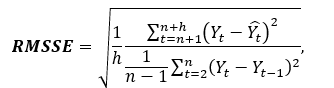

In [ ]:
def get_day_splits(sales):
    train_days = [x for x in sales.columns if x.find("d_") == 0][:1913]
    val_days = [x for x in sales.columns if x.find("d_") == 0][1913:]
    forecast_days = [x for x in sales.columns if x.find("F_") == 0]
    return train_days, val_days, forecast_days

def RMSSE(ground_truth, forecast, train):
    ''' Calculates the RMSSE score for all series in the dataframe. '''
    num = ((ground_truth - forecast)**2).sum(axis=1)
    den = 1/(n-1) * ((train[:, 1:] - train[:, :-1]) ** 2).sum(axis=1)  
    rmsse = (1/h * num/den) ** 0.5

    return rmsse

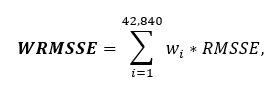

In [ ]:
h = 28
n = 1913

def WRMSSE(sales, agg, train_days, val_days, forecast_days):
    ''' Calculates the WRMSSE score for the model prediction '''
    ground_truth_df = np.array(sales[val_days])
    forecast_df = np.array(sales[forecast_days])
    train_df = np.array(sales[train_days])

    ground_truth_agg_df = np.array(agg[val_days])
    forecast_agg_df = np.array(agg[forecast_days])
    train_agg_df = np.array(agg[train_days])
            
    sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_df)
    agg["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_agg_df)

    sales["wrmsse"] = sales["weight"] * sales["rmsse"]
    agg["wrmsse"] = agg["weight"] * agg["rmsse"]

    wrmsse = sales["wrmsse"].sum() + agg["wrmsse"].sum()
    
    return wrmsse

# 6. Naive Approaches

1. Simple Moving Average of last 30 days 
2. Exponentially Weighted Average of last 30 days
3. Simple Average of last 28 days 
4. Simple Average of last 28 days grouped by weekday
5. Average Sales on the given date since last few years
6. Average Sales on the day since last few months
7. Same as last 28 days
8. Same as Last Year during this period

## 6.1 Simple Moving Average of last 30 days


In [ ]:
def SMA(train, horizon, window):
    ''' Computes simple moving average for the horizon '''

    train_arr = train.values

    for i in range(horizon):
        train_arr = np.hstack([train_arr, np.mean(train_arr[:, -window:], axis=1).reshape(-1,1)])

    return train_arr[:,-horizon:]

In [ ]:
preds = SMA(train, 28, 30)
preds_df = pd.DataFrame(preds, columns =  [f'F_{i}' for i in range(1914,1942)])
df_sales_sma = pd.concat([df_sales, preds_df], axis=1)

df_sales_sma.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1.055737,1.090928,1.093959,1.097091,1.033661,1.068116,1.070387,1.072733,1.075158,1.010996


In [ ]:
df_sales_sma = calculate_weightsL12(df_sales_sma, df_cal, df_price)

100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


In [ ]:
agg_df_sma = calculate_weightsALL(df_sales_sma, level_groupings)

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_sma)

In [ ]:
df_sales_sma['weight'].sum() + agg_df_sma['weight'].sum()

1.0

In [ ]:
wrmsse_sma = WRMSSE(df_sales_sma, agg_df_sma, train_days, val_days, forecast_days)
print("WRMSSE using SMA (Window=30 Days):", wrmsse_sma)

WRMSSE using SMA (Window=30 Days): 1.0867016409340657


## 6.2 Exponentially Weighted Average of last 30 days

Formula:

EMA(current) = ((Sales(current) - EMA(prev)) x Multiplier) + EMA(prev)

In [ ]:
def EMA(train, horizon, window):
    ''' Computes exponentially weighted average for one day in future, then use the same value for the horizon '''
    train_arr = train.values
    initial = np.mean(train_arr[:,-window:], axis=1)
    mul = 2/float(window+1)

    ema_curr = (train_arr[:, -1] - np.mean(train_arr[:, -window:], axis=1))*mul + np.mean(train_arr[:, -window:],axis=1)
    
    return np.hstack([ema_curr.reshape(-1,1)]*horizon)

In [ ]:
preds = EMA(train, 28, 30)
preds_df = pd.DataFrame(preds, columns =  [f'F_{i}' for i in range(1914,1942)])
df_sales_ema = pd.concat([df_sales, preds_df], axis=1)

df_sales_ema.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.968817,0.968817,0.968817,0.968817,0.968817,0.968817,0.968817,0.968817,0.968817,0.968817


In [ ]:
df_sales_ema = calculate_weightsL12(df_sales_ema, df_cal, df_price)

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


In [ ]:
agg_df_ema = calculate_weightsALL(df_sales_ema, level_groupings)

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_ema)

In [ ]:
df_sales_ema['weight'].sum() + agg_df_ema['weight'].sum()

1.0

In [ ]:
wrmsse_ema = WRMSSE(df_sales_ema, agg_df_ema, train_days, val_days, forecast_days)
print("WRMSSE using EMA (Window=30 Days):", wrmsse_ema)

WRMSSE using EMA (Window=30 Days): 1.1038252806790645


## 6.3 Simple Average of last 28 days

In [ ]:
df_sales_last28 = df_sales[['id']+[x for x in df_sales.columns if 'd_' in x and int(x.split('_')[1])>=1886 and int(x.split('_')[1])<=1913]]
df_sales_last28.head(1)

,id,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_evaluation,1,0,0,0,0,0,1,0,4,...,1,3,0,1,1,1,3,0,1,1


In [ ]:
preds_df = pd.DataFrame([np.mean(df_sales_last28.iloc[:,1:], axis=1)]*28).T
preds_df.columns = [f'F_{i}' for i in range(1914,1942)]
df_sales_sa = pd.concat([df_sales, preds_df], axis=1)

df_sales_sa.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286


In [ ]:
df_sales_sa = calculate_weightsL12(df_sales_sa, df_cal, df_price)

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


In [ ]:
agg_df_sa = calculate_weightsALL(df_sales_sa, level_groupings)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_sa)

In [ ]:
df_sales_sa['weight'].sum() + agg_df_sa['weight'].sum()

1.0

In [ ]:
wrmsse_sa = WRMSSE(df_sales_sa, agg_df_sa, train_days, val_days, forecast_days)
print("WRMSSE using Simple Average (Window=28 Days):", wrmsse_sa)

WRMSSE using Simple Average (Window=28 Days): 1.1182948282668468


## 6.4 Simple Average of last 28 days grouped by weekday

In [ ]:
df_sales_last28.head(1)

,id,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_evaluation,1,0,0,0,0,0,1,0,4,...,1,3,0,1,1,1,3,0,1,1


In [ ]:
df_sales_last28 = pd.melt(df_sales_last28, id_vars=['id'], var_name='d', value_name='sales')
df_sales_last28.head()

,id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,d_1886,1
1,HOBBIES_1_002_CA_1_evaluation,d_1886,1
2,HOBBIES_1_003_CA_1_evaluation,d_1886,0
3,HOBBIES_1_004_CA_1_evaluation,d_1886,0
4,HOBBIES_1_005_CA_1_evaluation,d_1886,1


In [ ]:
df_sales_last28 = df_sales_last28.merge(df_cal[['d', 'wday']], on=['d'], how='inner')
df_sales_last28.head()

,id,d,sales,wday
0,HOBBIES_1_001_CA_1_evaluation,d_1886,1,3
1,HOBBIES_1_002_CA_1_evaluation,d_1886,1,3
2,HOBBIES_1_003_CA_1_evaluation,d_1886,0,3
3,HOBBIES_1_004_CA_1_evaluation,d_1886,0,3
4,HOBBIES_1_005_CA_1_evaluation,d_1886,1,3


In [ ]:
query_df = df_sales_last28.groupby(['id', 'wday']).mean()
query_df.head()

sales
id                          wday       
FOODS_1_001_CA_1_evaluation 1      0.75
                            2      0.50
                            3      3.00
                            4      0.75
                            5      1.50

In [ ]:
wday_dict = df_cal.loc[1913:1940, ['d', 'wday']].set_index('d').to_dict()['wday']

preds = []
for id in df_sales['id']:
    tmp = [] 
    for day in range(1914, 1942):
        wday = wday_dict[f'd_{day}']
        tmp.append(list(query_df.loc[(id, wday)])[0])
    preds.append(tmp)

preds_df = np.array(preds)

In [ ]:
preds_df = pd.DataFrame(preds_df, columns = [f'F_{i}' for i in range(1914,1942)])
df_sales_sa28 = pd.concat([df_sales, preds_df], axis=1)
df_sales_sa28.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.25,1.25,1.0,0.5,1.25,0.75,1.75,0.25,1.25,1.0


In [ ]:
df_sales_sa28 = calculate_weightsL12(df_sales_sa28, df_cal, df_price)

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


In [ ]:
agg_df_sa28 = calculate_weightsALL(df_sales_sa28, level_groupings)

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_sa28)

In [ ]:
df_sales_sa28['weight'].sum() + agg_df_sa28['weight'].sum()

1.0

In [ ]:
wrmsse_sa28 = WRMSSE(df_sales_sa28, agg_df_sa28, train_days, val_days, forecast_days)
print("WRMSSE using Simple Average Grouped by Weekday (Window=28 Days):", wrmsse_sa28)

WRMSSE using Simple Average Grouped by Weekday (Window=28 Days): 0.7894542828501339


## 6.5 Average Sales on the given date for last 2 years

In [ ]:
df_cal.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,d_,event_name,event_type
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,1,NaN,NaN


In [ ]:
df_cal['date'] =  pd.to_datetime(df_cal['date'])
df_cal['MM-DD'] = df_cal['date'].dt.strftime('%m-%d')
df_cal.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,d_,event_name,event_type,MM-DD
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,1,NaN,NaN,01-29


In [ ]:
tmp  = df_cal[df_cal['MM-DD']=='05-22']['d'].tolist()[:-1]  
tmp

['d_114', 'd_480', 'd_845', 'd_1210', 'd_1575']

In [ ]:
1941-366, 1941-366-365, 1941-366-365-365, 1941-366-365-365-365, 1941-366-365-365-365-366

(1575, 1210, 845, 480, 114)

In [ ]:
df_sales_saDateLast2y = df_sales.copy()

In [ ]:
for day in range(1914, 1942):
    df_sales_saDateLast2y['F_'+str(day)] = df_sales_saDateLast2y.loc[:, ['d_'+str(day-366), 'd_'+str(day-366-365)]].mean(axis=1) 
    # if you need to calculate mean over all years use these terms as well 'd_'+str(day-366-365-365) 'd_'+str(day-366-365-365-365), 'd_'+str(day-366-365-365-366)

In [ ]:
df_sales_saDateLast2y.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.0,0.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0


In [ ]:
df_sales_saDateLast2y = calculate_weightsL12(df_sales_saDateLast2y, df_cal, df_price)

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


In [ ]:
df_sales_saDateLast2y.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941,weight
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,0.000005


In [ ]:
agg_df_saDateLast2y = calculate_weightsALL(df_sales_saDateLast2y, level_groupings)

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


In [ ]:
agg_df_saDateLast2y.head(1)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,F_1939,F_1940,F_1941,item_id,dept_id,cat_id,store_id,state_id,level,weight
0,32631.0,31749.0,23783.0,25412.0,19146.0,29211.0,28010.0,37932.0,32736.0,25572.0,...,30542.0,29842.0,33326.5,all,all,all,all,all,1,0.083333


In [ ]:
df_sales_saDateLast2y['weight'].sum() + agg_df_saDateLast2y['weight'].sum()

1.0

In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_saDateLast2y)

In [ ]:
wrmsse_saDateLast2y = WRMSSE(df_sales_saDateLast2y, agg_df_saDateLast2y, train_days, val_days, forecast_days)
print("WRMSSE using Simple Average Sales on the given date last 2 years:", wrmsse_saDateLast2y)

WRMSSE using Simple Average Sales on the given date last 2 years: 1.7959968027514586


## 6.6 Average Sales on given date last few months

In [ ]:
df_cal['date'] =  pd.to_datetime(df_cal['date'])
df_cal['DD'] = df_cal['date'].apply(lambda x: x.day)
df_cal.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,d_,event_name,event_type,DD
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,1,NaN,NaN,29


In [ ]:
#checking the code
day = 1934
day_of_month = int(df_cal[df_cal['d_']==day]['DD'])
DaysLast3M = df_cal.loc[(df_cal['d_']<day) & (df_cal['DD']==day_of_month)]['d'].tolist()[-3:]
DaysLast3M

['d_1844', 'd_1873', 'd_1904']

In [ ]:
df_sales_saDayLast3M = df_sales.copy()

In [ ]:
for day in range(1914, 1942): 
    day_of_month = int(df_cal[df_cal['d_']==day]['DD'])
    corr_DaysLast3M = df_cal.loc[(df_cal['d_']<day) & (df_cal['DD']==day_of_month)]['d'].tolist()[-3:]
    df_sales_saDayLast3M['F_'+str(day)] = df_sales_saDayLast3M.loc[:, corr_DaysLast3M].mean(axis=1)

In [ ]:
df_sales_saDayLast3M.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1.333333,0.333333,0.666667,1.333333,0.333333,1.666667,1.0,2.0,1.333333,2.0


In [ ]:
df_sales_saDayLast3M = calculate_weightsL12(df_sales_saDayLast3M, df_cal, df_price)

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


In [ ]:
df_sales_saDayLast3M.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941,weight
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.333333,0.666667,1.333333,0.333333,1.666667,1.0,2.0,1.333333,2.0,0.000005


In [ ]:
agg_df_saDayLast3M = calculate_weightsALL(df_sales_saDayLast3M, level_groupings)

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


In [ ]:
agg_df_saDayLast3M.head(1)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,F_1939,F_1940,F_1941,item_id,dept_id,cat_id,store_id,state_id,level,weight
0,32631.0,31749.0,23783.0,25412.0,19146.0,29211.0,28010.0,37932.0,32736.0,25572.0,...,44675.0,41491.333333,37773.333333,all,all,all,all,all,1,0.083333


In [ ]:
df_sales_saDayLast3M['weight'].sum() + agg_df_saDayLast3M['weight'].sum()

1.0

In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_saDayLast3M)

In [ ]:
wrmsse_saDayLast3M = WRMSSE(df_sales_saDayLast3M, agg_df_saDayLast3M, train_days, val_days, forecast_days)
print("WRMSSE using Simple Average Sales on a given day of the month last 3 months:", wrmsse_saDayLast3M)

WRMSSE using Simple Average Sales on a given day of the month last 3 months: 1.2169429906813274


## 6.7 Same as last 28 Days

In [ ]:
preds_df = df_sales.loc[:, [f'd_{day}' for day in range(1886, 1914)]]
preds_df.columns = [f'F_{day}' for day in range(1914,1942)]
preds_df.head(1)

,F_1914,F_1915,F_1916,F_1917,F_1918,F_1919,F_1920,F_1921,F_1922,F_1923,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,1,0,0,0,0,0,1,0,4,2,...,1,3,0,1,1,1,3,0,1,1


In [ ]:
df_sales_same28d = pd.concat([df_sales,preds_df], axis=1)
df_sales_same28d.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1


In [ ]:
df_sales_same28d = calculate_weightsL12(df_sales_same28d, df_cal, df_price)

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


In [ ]:
agg_df_same28d = calculate_weightsALL(df_sales_same28d, level_groupings)

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


In [ ]:
df_sales_same28d['weight'].sum() + agg_df_same28d['weight'].sum()

1.0

In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_same28d)

In [ ]:
wrmsse_same28d = WRMSSE(df_sales_same28d, agg_df_same28d, train_days, val_days, forecast_days)
print("WRMSSE using Same Sales Data as last 28 Days:", wrmsse_same28d)

WRMSSE using Same Sales Data as last 28 Days: 0.8834854605107758


## 6.8 Same as Last Year during this period



In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
df_cal['date'] = pd.to_datetime(df_cal['date'])

In [ ]:
start_date =  df_cal[df_cal['d_']==1914]['date'].tolist()[0] - relativedelta(years=1)
start_day = df_cal[df_cal['date']==start_date]['d_'].tolist()[0]
lastyear28days = [f'd_{x}' for x in range(start_day, start_day+28)]

In [ ]:
forecast28days = [f'F_{x}' for x in range(1914, 1942)]
preds_df = df_sales.copy()[lastyear28days]
preds_df.columns = forecast28days

df_sales_lastyear28days = pd.concat([df_sales, preds_df], axis=1)
df_sales_lastyear28days.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,F_1932,F_1933,F_1934,F_1935,F_1936,F_1937,F_1938,F_1939,F_1940,F_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_sales_lastyear28days = calculate_weightsL12(df_sales_lastyear28days, df_cal, df_price)

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


In [ ]:
agg_df_lastyear28days = calculate_weightsALL(df_sales_lastyear28days, level_groupings)

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [ ]:
df_sales_lastyear28days['weight'].sum() + agg_df_lastyear28days['weight'].sum()

1.0

In [ ]:
train_days, val_days, forecast_days = get_day_splits(df_sales_lastyear28days)

In [ ]:
wrmsse_lastyear28days = WRMSSE(df_sales_lastyear28days, agg_df_lastyear28days, train_days, val_days, forecast_days)
print("WRMSSE using Same as last year during this period:", wrmsse_lastyear28days)

WRMSSE using Same as last year during this period: 1.7581034031950258


# 7. Summary

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Approach", "WRMSSE"]
x.add_rows(
    [
        ["Simple Moving Average of last 30 days", 1.08],
        ["Exponentially Weighted Average of last 30 days", 1.10],
        ["Simple Average of last 28 days", 1.11],
        ["Simple Average of last 28 days grouped by weekday", 0.78],
        ["Average Sales on the given date since last few years", 1.79],
        ["Average Sales on the day since last few months", 1.21],
        ["Same as last 28 days", 0.88],
        ["Same as Last Year during this period", 1.75]
         
    ]
)

print(x)

+------------------------------------------------------+--------+
|                       Approach                       | WRMSSE |
+------------------------------------------------------+--------+
|        Simple Moving Average of last 30 days         |  1.08  |
|    Exponentially Weighted Average of last 30 days    |  1.1   |
|            Simple Average of last 28 days            |  1.11  |
|  Simple Average of last 28 days grouped by weekday   |  0.78  |
| Average Sales on the given date since last few years |  1.79  |
|    Average Sales on the day since last few months    |  1.21  |
|                 Same as last 28 days                 |  0.88  |
|         Same as Last Year during this period         |  1.75  |
+------------------------------------------------------+--------+


Clearly, these are the 2 approaches which trump over others: 
1.  Simple Average of last 28 days grouped by weekday  
2.  Same as last 28 days  


# 8. References 

- https://www.kaggle.com/code/qcw171717/other-naive-forecasts-submission-score